# London’s Bike-share Demand Prediction Using Machine Learning (ML) Algorithms

This notebook explores London's bike-share demand, and develops prediction models using Decision Tree and XGBoost Regressors.

In [1]:
# Loading the necessary libraries

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for model input and data preparation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing

# model
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# for model evaluation 
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

import statsmodels.api as sm


The dataset was obtained from 3 sources, namely, the hourly cycling count data from cycling.data.tfl.gov.uk, weather data from freemeteo.com, and holidays data from www.gov.uk/bank-holidays. 

Metadata:
- 'timestamp' - timestamp field for grouping the data
- 'cnt' - the count of a new bike shares
- 't1' - real temperature in C
- 't2' - temperature in C 'feels like'
- 'hum' - humidity in percentage
- 'wind_speed' - wind speed in km/h
- 'weather_code' - category of the weather
- 'is_holiday' - boolean field - 1 holiday / 0 non holiday
- 'is_weekend' - boolean field - 1 if the day is weekend
- 'season' - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.
- 'weather_code' category description: 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

- Data is automatically collected via Santander bikeshares.


In [2]:
bike = pd.read_csv('bikeshare.csv')
# The length of dataset is from start of 2015 to start of 2017

### Data Cleaning and EDA

In [3]:
# Checking the bike info, we notice that timestamp is not in datetime format
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [4]:
# Setting index to timestamp index, changing weather code and season to obj
bike.index = pd.to_datetime(bike['timestamp'])
bike.sort_index(inplace=True)

bike.drop('timestamp', axis=1, inplace=True)
bike.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


We note the categorical features, which we will need to convert to dummy variables later.

In [5]:
# The dataset does not have any na data
bike.isna().any()

# Fortunately, the TFL cycling data is complete, and there is no missing data to work with

cnt             False
t1              False
t2              False
hum             False
wind_speed      False
weather_code    False
is_holiday      False
is_weekend      False
season          False
dtype: bool

In [6]:
bike.shape

(17414, 9)

In [7]:
# We create the columns so it is easier to work with later
bike['hour'] = bike.index.hour
bike['day_of_month'] = bike.index.day
bike['day_of_week']  = bike.index.dayofweek
bike['month'] = bike.index.month
bike.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1


In [8]:
bike.columns

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season', 'hour', 'day_of_month', 'day_of_week', 'month'],
      dtype='object')

### Visualisations

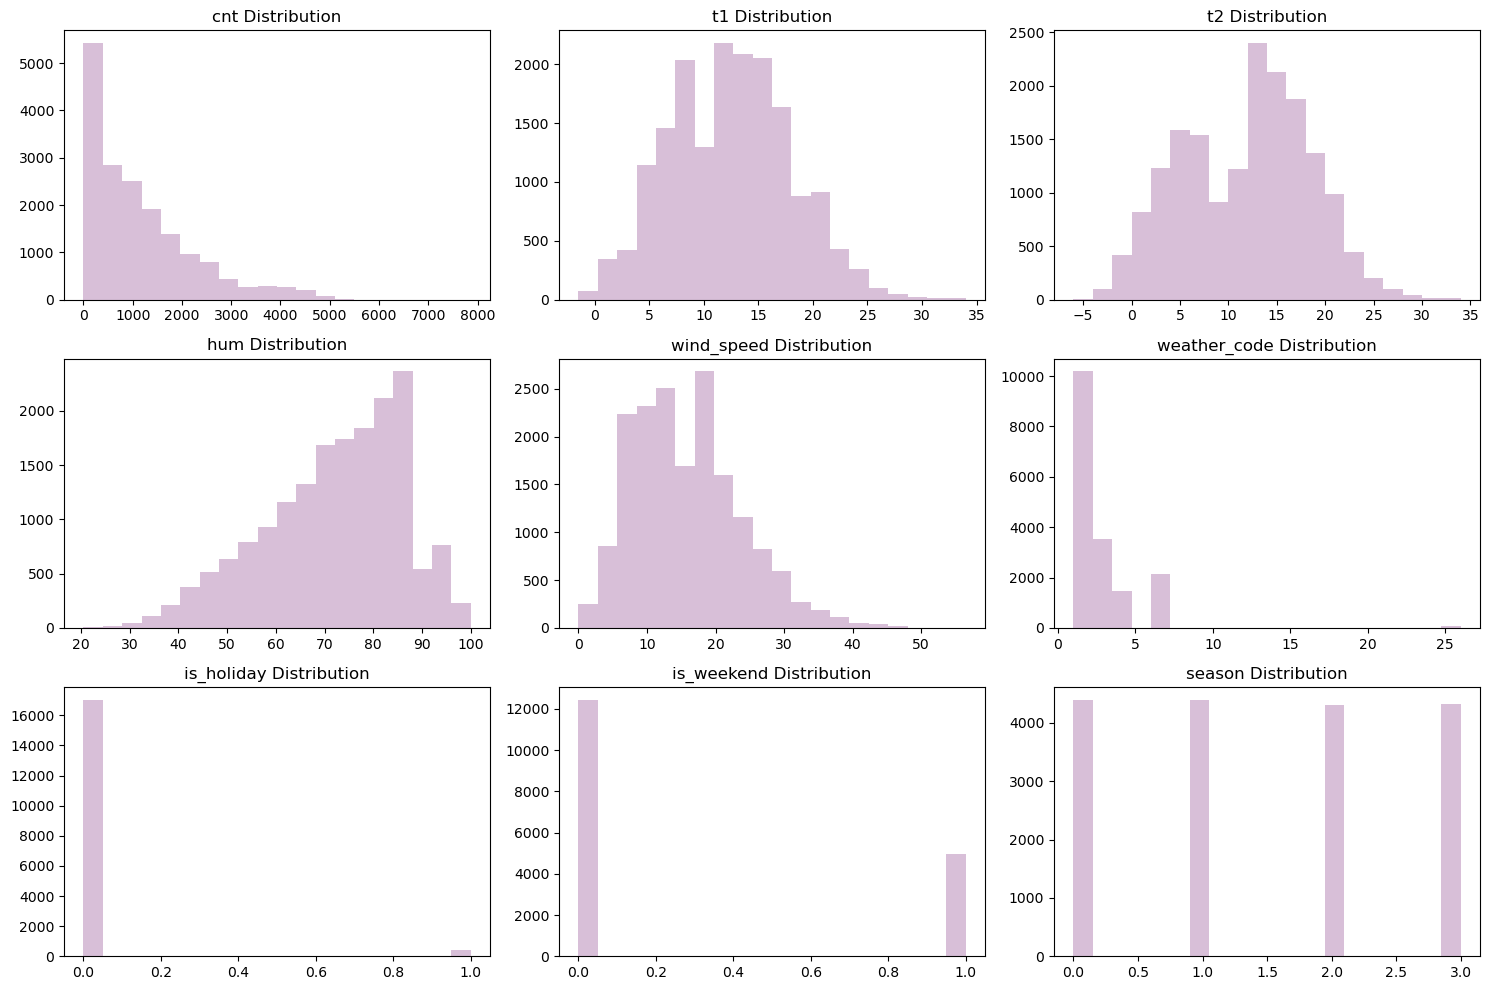

In [9]:
# create a 3 x 3 grid of subplots 
fig, ax = plt.subplots(3,3, figsize = (15,10))

# flatten array to make easier to access each subplot
ax = ax.ravel()

# loop over each column in the dataframe and plot a histogram
for i,column in enumerate(bike.iloc[:,:9].columns):
    ax[i].hist(bike.iloc[:,:9][column], bins = 20, color='thistle')
    ax[i].set_title('{} Distribution'.format(column))
    
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.savefig('distribution.png') 
plt.show()


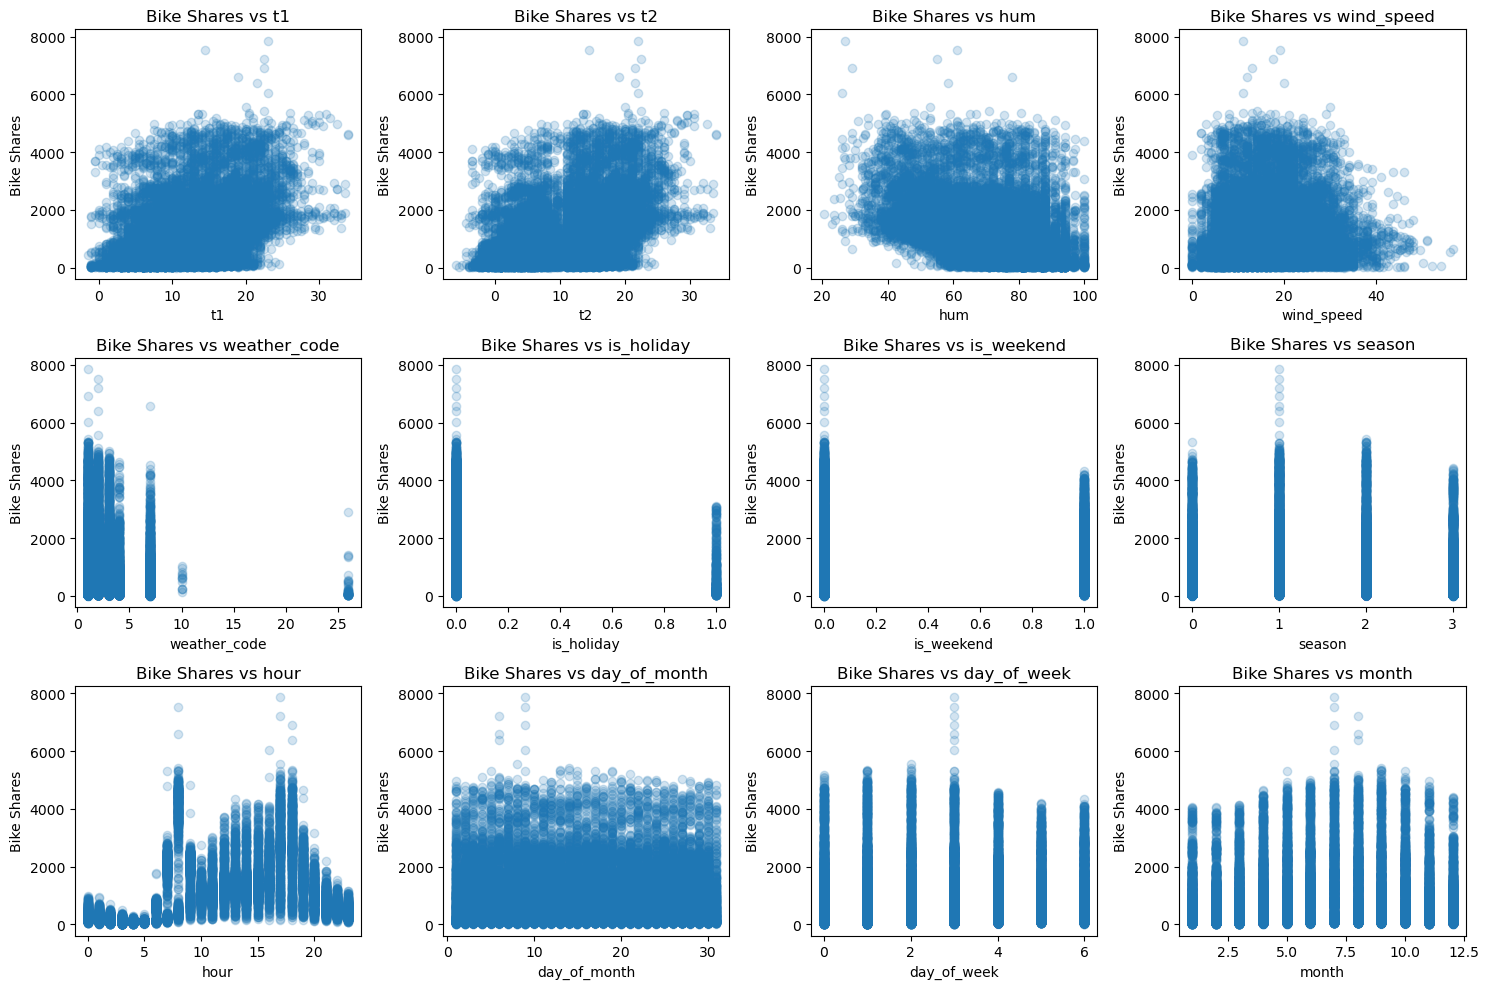

In [10]:
# create a 3 x 3 grid of subplots 
fig, ax = plt.subplots(3,4, figsize = (15,10))

# flatten array to make easier to access each subplot
ax = ax.ravel()

# loop over each column in the dataframe and plot a histogram
for i,column in enumerate(bike.columns[1:]):
    ax[i].scatter(bike[column], bike['cnt'], alpha = 0.2)
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Bike Shares')
    ax[i].set_title('Bike Shares vs {}'.format(column))
    
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

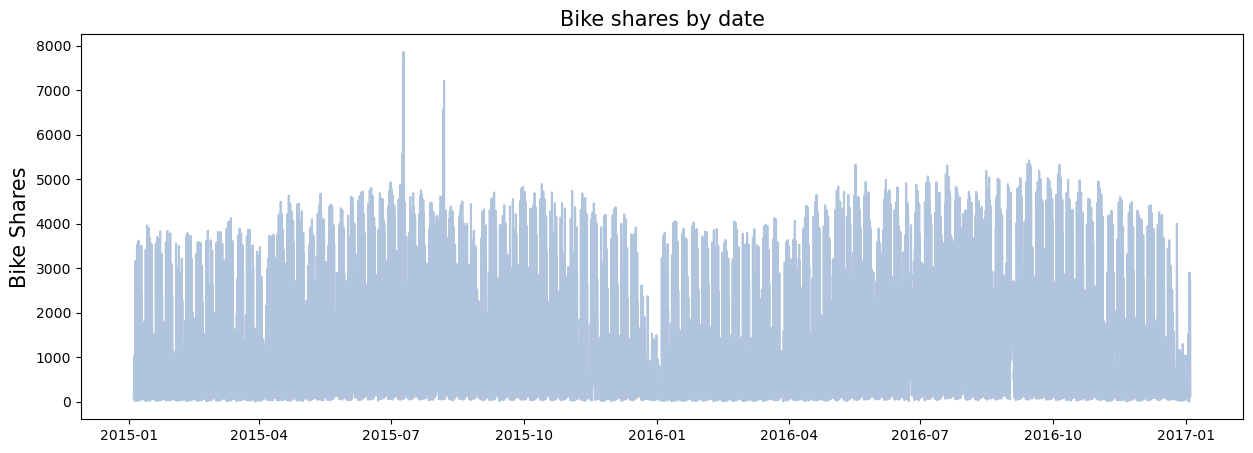

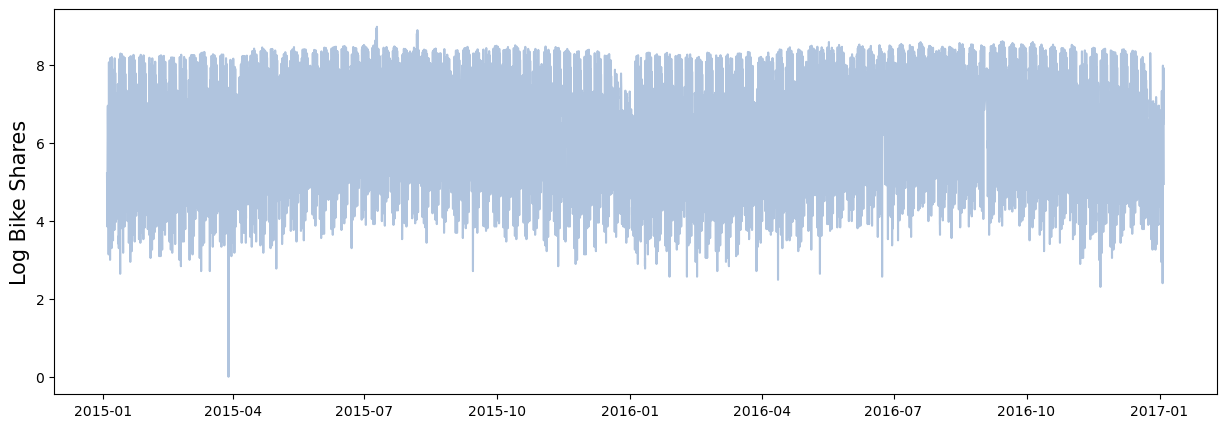

In [11]:
# Plotting a time series plot
plt.figure(figsize=(15, 5))
plt.plot(bike.index, bike.cnt, c='lightsteelblue')
plt.title('Bike shares by date', fontsize=15)
plt.ylabel('Bike Shares', fontsize=15)

plt.savefig('bikeshares1.png') 
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(bike.index, np.log1p(bike.cnt), c= 'lightsteelblue')
plt.ylabel('Log Bike Shares', fontsize=15)

plt.savefig('bikeshares2.png') 
plt.show()

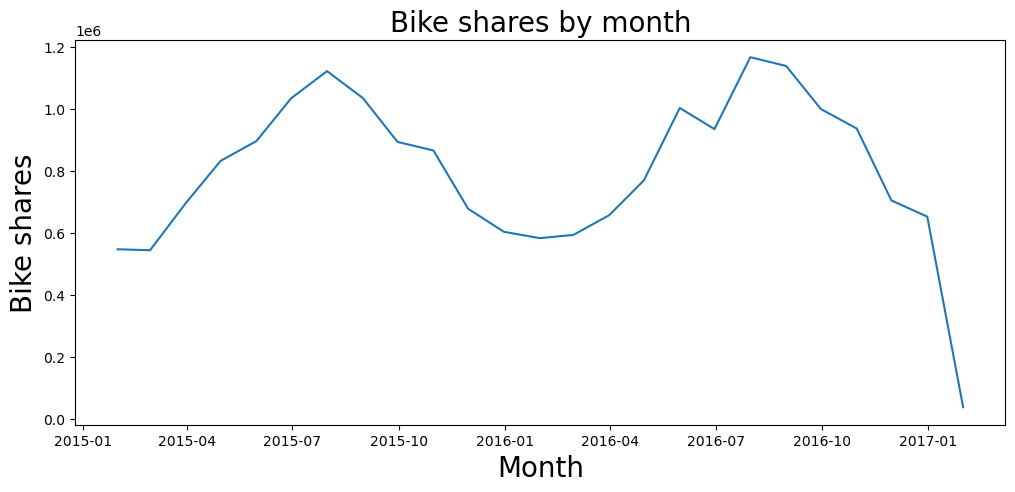

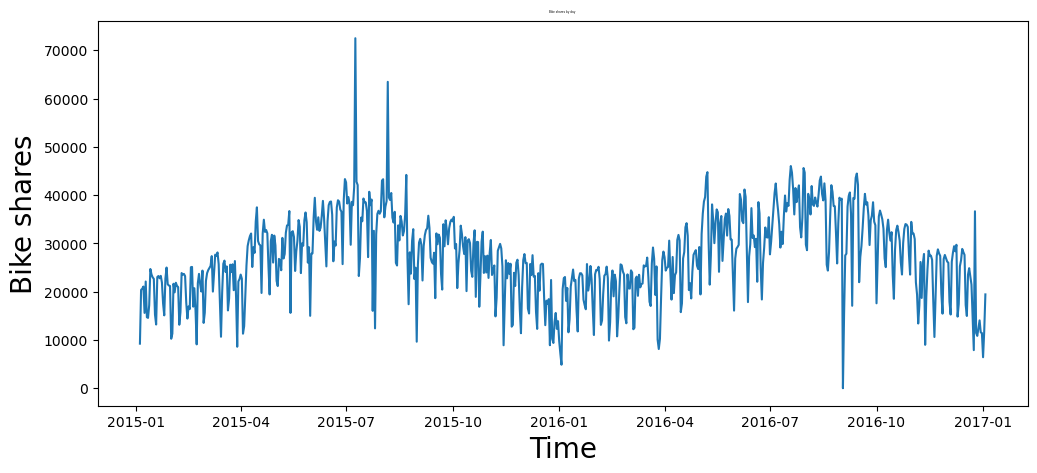

In [12]:
# Plotting time-series for month and day frequency
bike_month = bike.resample('M').sum()
plt.figure(figsize=(12,5))
ax = sns.lineplot(x=bike_month.index,y=bike_month.cnt, data=bike_month)
ax.set_title('Bike shares by month', fontsize=20)
ax.set_xlabel('Month', fontsize=20)
ax.set_ylabel('Bike shares', fontsize=20)

bike_week = bike.resample('D').sum()
plt.figure(figsize=(12,5))
ax = sns.lineplot(x=bike_week.index,y=bike_week.cnt, data=bike_week)
ax.set_title('Bike shares by day', fontsize=2)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Bike shares', fontsize=20)
plt.show()

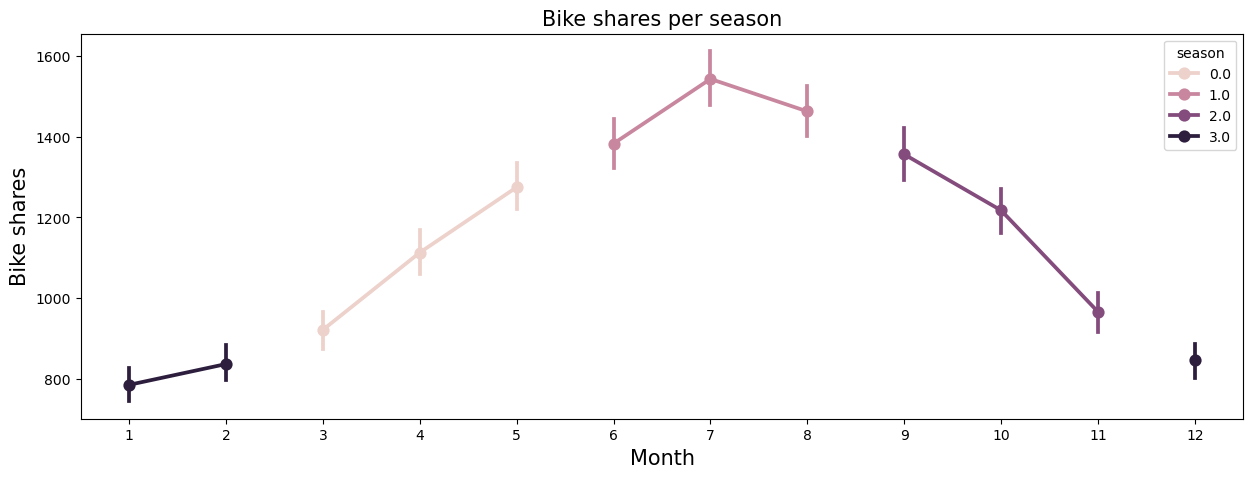

In [13]:
plt.figure(figsize=(15,5))
ax = sns.pointplot(data=bike,hue=bike.season,y=bike.cnt,x=bike.month)
ax.set_title('Bike shares per season', fontsize=15)
ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Bike shares', fontsize=15)
plt.savefig('season.png') 
plt.show()

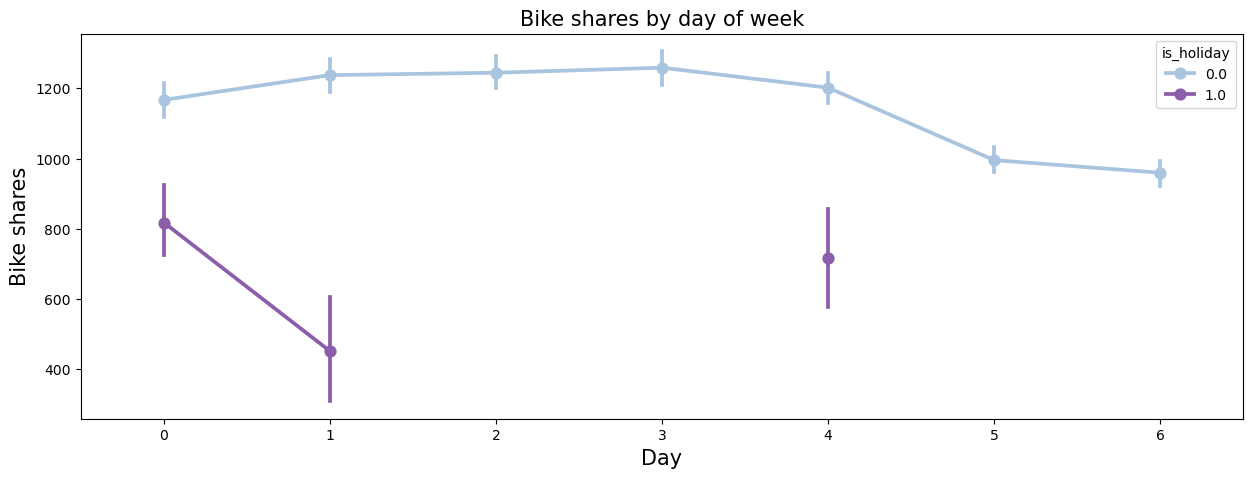

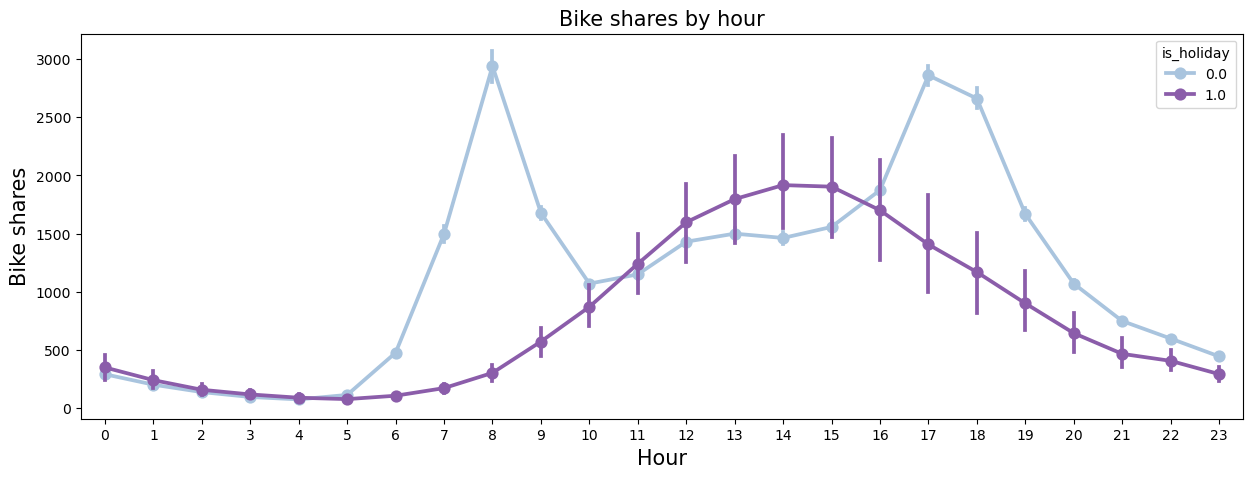

In [14]:
plt.figure(figsize=(15, 5))
ax = sns.pointplot(x='day_of_week', y='cnt',hue='is_holiday', data=bike, palette = 'BuPu')
ax.set_title('Bike shares by day of week', fontsize=15)
ax.set_xlabel('Day', fontsize=15)
ax.set_ylabel('Bike shares', fontsize=15)
plt.savefig('day_of_week.png') 
plt.show()

plt.figure(figsize=(15, 5))
ax = sns.pointplot(x='hour', y='cnt',hue='is_holiday', data=bike,palette = 'BuPu')
ax.set_title('Bike shares by hour', fontsize=15)
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Bike shares', fontsize=15)
plt.show()

- From the month pov, there seem to be a seasonality where ridership is higher in the summer. We observe that the monthly difference in bike share is rather large, **hence we should include factor by month instead of by season.** However, we would still need to test whether this difference is significant later on.
- From the day pov, ridership is higher during working days, and at commute hours. Hence, the day of the week column is not that useful, and **we would instead just use is_weekend instead.**
- We also notice that bike share is lower on holidays, and bike share the trend tend to be during mid day/afternoon as opposed to morning and afternoon peak.

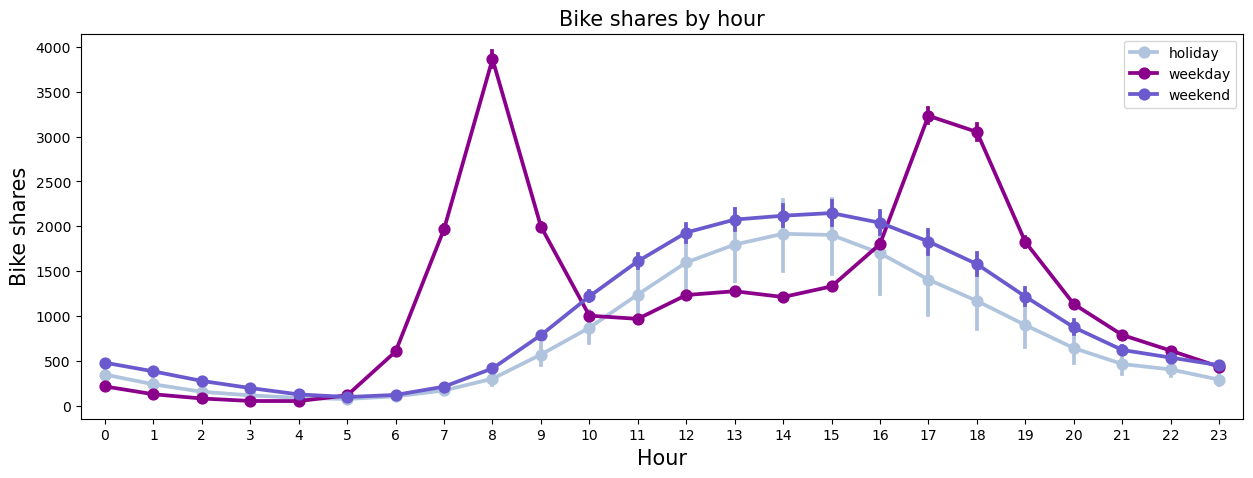

In [15]:
plt.figure(figsize=(15, 5))
ax= sns.pointplot(x='hour', y='cnt', data=bike[bike['is_holiday']==1], label='holiday', color='lightsteelblue')
ax= sns.pointplot(x='hour', y='cnt', data=bike[bike['is_weekend']==0], label='weekday', color='darkmagenta')
ax= sns.pointplot(x='hour', y='cnt', data=bike[bike['is_weekend']==1], label='weekend', color='slateblue')
ax.set_title('Bike shares by hour', fontsize=15)
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Bike shares', fontsize=15)
plt.savefig('hour.png') 
plt.show()

Since holiday and weekend generally exhibit similar patterns, we will create new feature classes that indicates either it is a workday or not

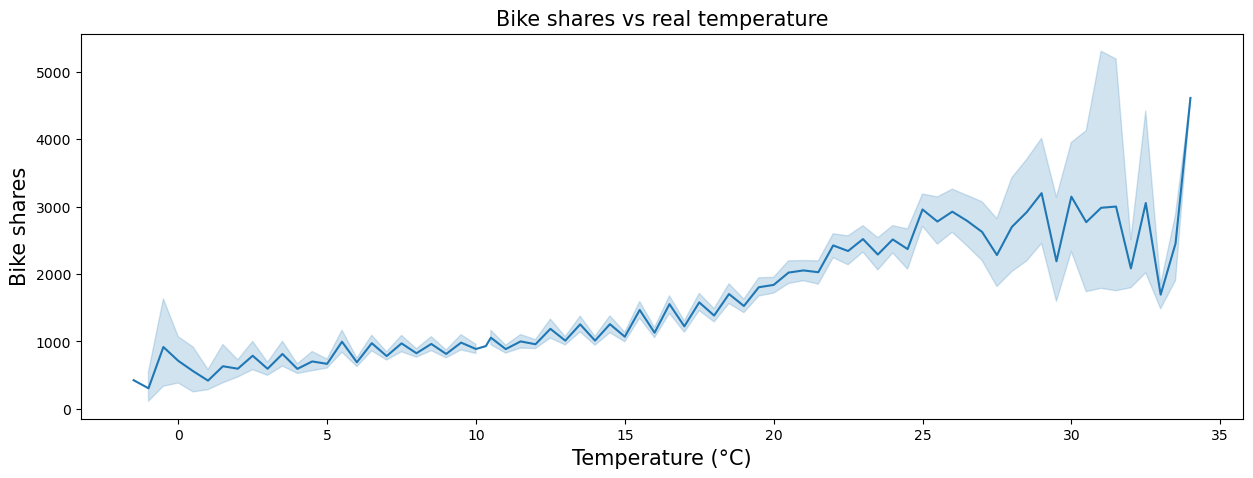

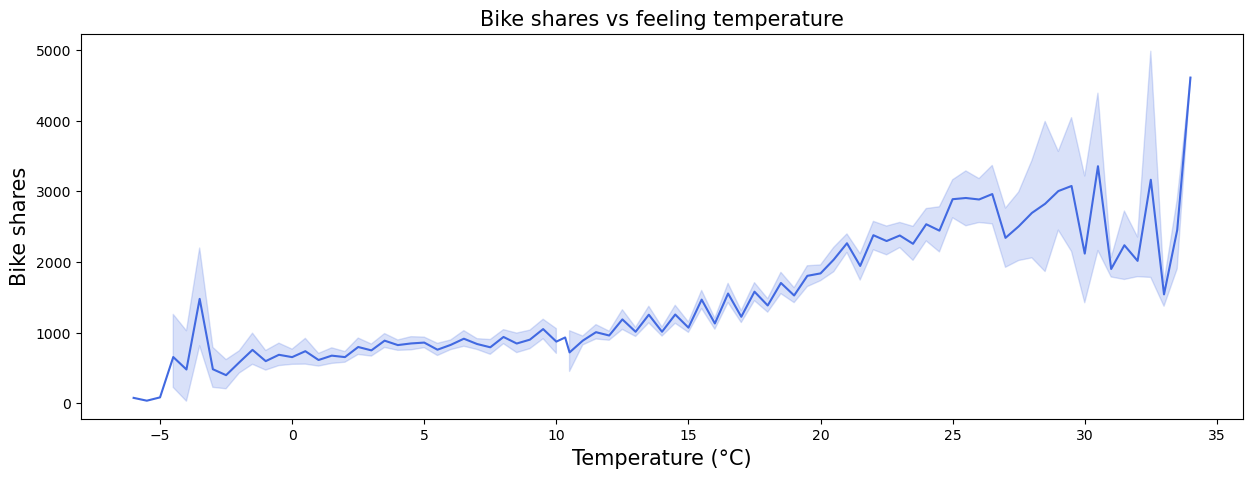

In [16]:
# Plotting against temperatures
# We choose to only fit with feeling temperature, as that is more likely to be related to impacting temperatures

plt.figure(figsize=(15,5))

ax = sns.lineplot(x='t1', y='cnt',data=bike)
ax.set_title('Bike shares vs real temperature', fontsize=15)
ax.set_xlabel('Temperature (°C)', fontsize=15)
ax.set_ylabel('Bike shares', fontsize=15)
plt.locator_params(axis='x', nbins=10)
plt.savefig('temperature1.png') 
plt.show()

plt.figure(figsize=(15,5))
ax = sns.lineplot(x='t2', y='cnt',data=bike, color='royalblue')
ax.set_title('Bike shares vs feeling temperature', fontsize=15)
ax.set_xlabel('Temperature (°C)', fontsize=15)
ax.set_ylabel('Bike shares', fontsize=15)
plt.locator_params(axis='x', nbins=10)
plt.savefig('temperature2.png') 
plt.show()

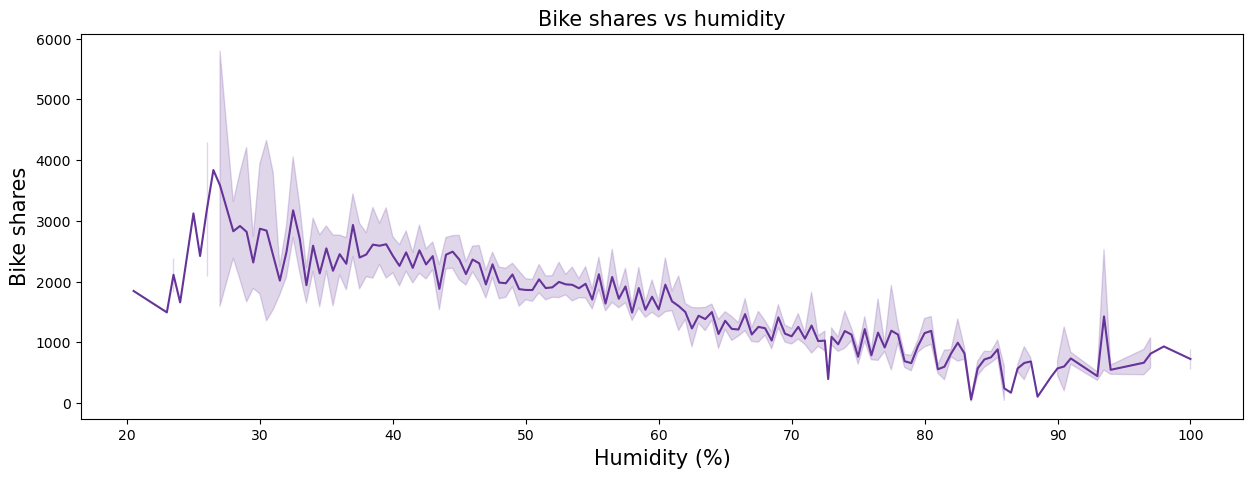

In [17]:
# Plotting against humidity
plt.figure(figsize=(15,5))

ax = sns.lineplot(x='hum', y='cnt',data=bike, color='rebeccapurple')
ax.set_title('Bike shares vs humidity', fontsize=15)
ax.set_xlabel('Humidity (%)', fontsize=15)
ax.set_ylabel('Bike shares', fontsize=15)
plt.locator_params(axis='x', nbins=10)
plt.savefig('humidity.png')
plt.show()

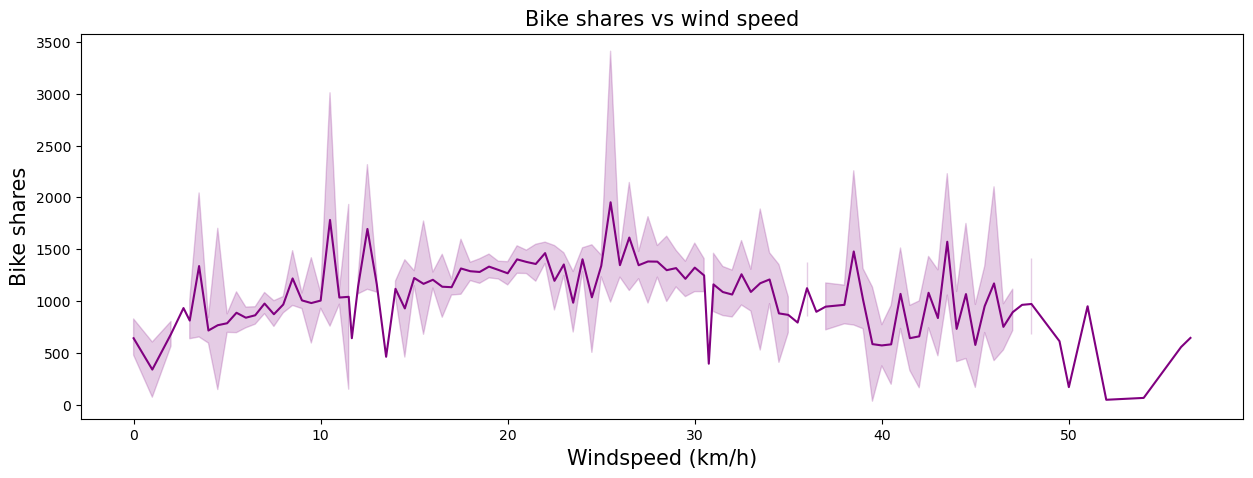

In [18]:
# Plotting against wind speed
plt.figure(figsize=(15,5))

ax = sns.lineplot(x='wind_speed', y='cnt',data=bike, color='purple')
ax.set_title('Bike shares vs wind speed', fontsize=15)
ax.set_xlabel('Windspeed (km/h)', fontsize=15)
ax.set_ylabel('Bike shares', fontsize=15)
plt.locator_params(axis='x', nbins=10)
plt.savefig('windspeed.png')
plt.show()

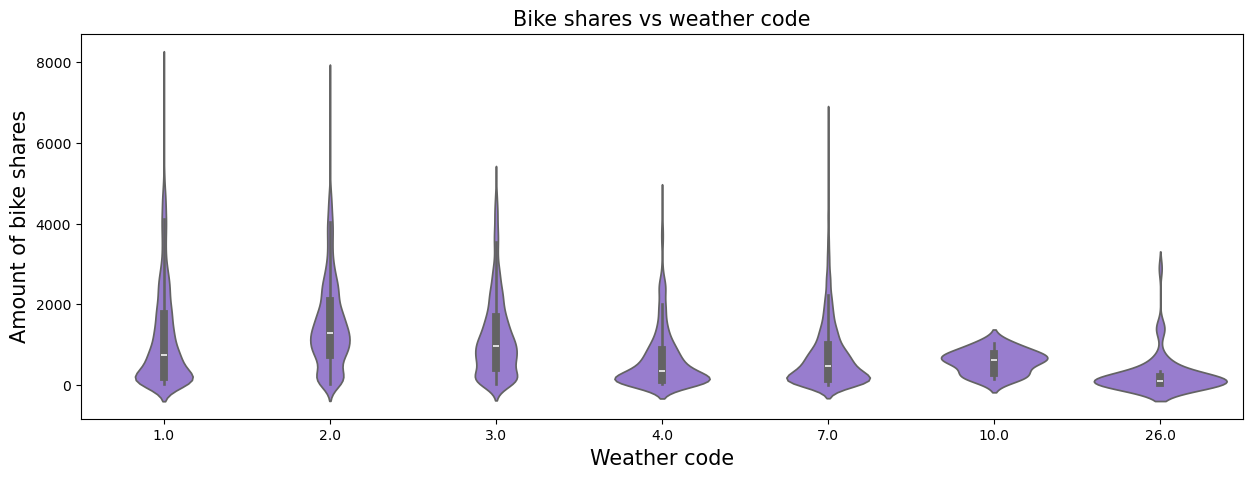

In [19]:
# Plotting against weather code
plt.figure(figsize=(15,5))
ax = sns.violinplot(data=bike,y=bike.cnt,x=bike.weather_code, color='mediumpurple')
ax.set_title('Bike shares vs weather code', fontsize=15)
ax.set_xlabel('Weather code', fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.savefig('weather_code.png')
plt.show()

In [20]:
bike.weather_code.value_counts()

weather_code
1.0     6150
2.0     4034
3.0     3551
7.0     2141
4.0     1464
26.0      60
10.0      14
Name: count, dtype: int64

### Feature Engineering

Features to engineer:
1. Remove 't1'
2. Engineer 'is-workday' from 'is_holiday' and 'is_weekend'. Week of the day


In [21]:
# Dropping columns used for visualisation
bike.drop(columns=['day_of_month','day_of_week'], inplace=True)

# Converting categorical columns to category
bike['weather_code']=bike['weather_code'].astype('category')
bike['season']=bike['season'].astype('category')

In [22]:
bike.columns

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season', 'hour', 'month'],
      dtype='object')

In [23]:
# Engineering 
bike1 = bike.copy()

# Creating workday to simplify
bike1['is_workday'] = (bike1['is_holiday'] == 0) & (bike1['is_weekend'] == 0)
bike1['is_workday'] = bike1['is_workday'].astype(int)

# Creating is_night to simplify hour
# Note: this was tested in the mode, but later observed that it is not helpful to improve the accuracy of the model.
bike1['is_night'] = 0
bike1.loc[(bike['hour'] < 7) | (bike1['hour'] > 21), 'is_night'] = 1

# Drop 't1'
bike1.drop(columns=['t1'], inplace=True)
bike1.head()

,cnt,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,is_workday,is_night
timestamp,,,,,,,,,,,,
2015-01-04 00:00:00,182,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,1,0,1
2015-01-04 01:00:00,138,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,1,0,1
2015-01-04 02:00:00,134,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,1,0,1
2015-01-04 03:00:00,72,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,1,0,1
2015-01-04 04:00:00,47,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,1,0,1


In [24]:
# Testing for skewness
from scipy.stats import skew

skewed = bike1.drop(columns=['weather_code', 'season']).skew()
skewed

cnt           1.325707
t2           -0.058352
hum          -0.572782
wind_speed    0.669011
is_holiday    6.509901
is_weekend    0.950457
hour         -0.003762
month        -0.004703
is_workday   -0.834619
is_night      0.522840
dtype: float64

only cnt and is_holiday need to be transformed. is_holiday has already been represented as is_workday, so no need for transformation.

<Axes: >

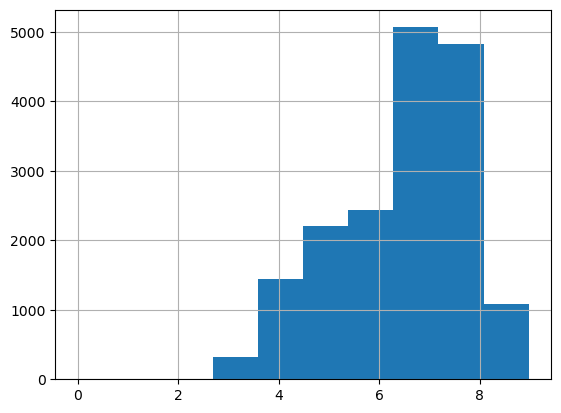

In [25]:
# Perform log transformation to cnt due to high skew
bike1['logcnt'] = np.log1p(bike1['cnt'])
bike1['logcnt'].hist()

In [26]:
print(bike1.shape)
print(bike1.columns)

(17414, 13)
Index(['cnt', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season', 'hour', 'month', 'is_workday', 'is_night',
       'logcnt'],
      dtype='object')


We might want to decide whether to choose t1 or t2 (as they are essentially representing the same thing).
We notice that the most important factors (based on correlation matrix) are, temperature, humidity and hour.

### DT Regressor 1

In [27]:
# Creating function
def split(X, y):
    
    # Splitting the data in chronological order
    # No standard scaling required we are only using tree-based method
    train_percent = 0.8
    
    split_index = int(train_percent * len(y))
    
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [28]:
train_features1 = ['t2', 'hum', 'wind_speed', 'hour', 'month', 'is_workday', 
                  'weather_code', 'season']
X1 = bike1[train_features1]
y1 = bike1['logcnt']

# Split
X1_train, X1_test, y1_train, y1_test = split(X1, y1)

(13931, 8) (3483, 8) (13931,) (3483,)


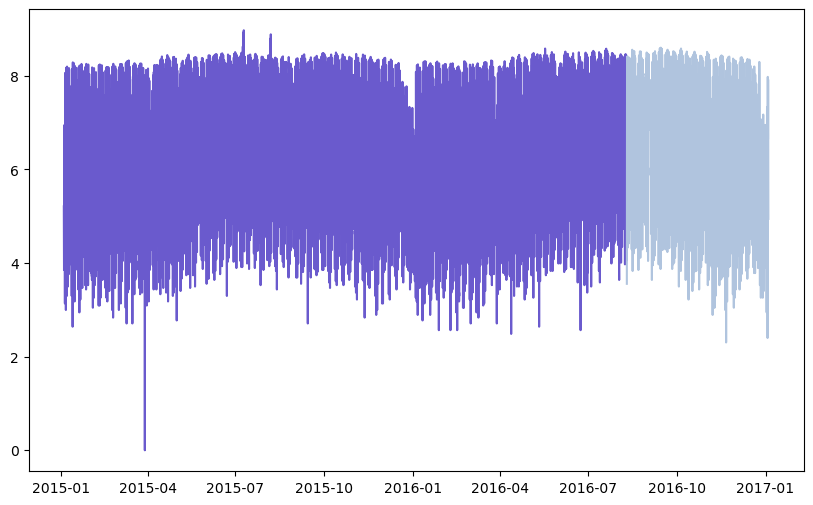

In [29]:
# Plotting train and test
plt.figure(figsize=(10, 6))
plt.plot(y1_train, color = 'slateblue', label='y_train')
plt.plot(y1_test, color = 'lightsteelblue', label='y_test')
plt.show()


In [30]:
# Defining gridsearch cv and dt_regressor

def dt_gridsearchcv(X, y):

    params = {
        'max_depth': [2, 5, 7, 10, 12],
        'min_samples_split': [2, 5, 7, 10, 12],
        'min_samples_leaf': [2, 5, 7, 10, 12]
    }
    
    # Create the Decision Tree Regressor model
    dt_regressor = DecisionTreeRegressor()
    
    # Create the GridSearchCV object with RMSE scoring
    grid_search = GridSearchCV(estimator=dt_regressor,
                              param_grid=params,
                              scoring={'neg_root_mean_squared_error': 'neg_root_mean_squared_error', 
                                    'r2_score': 'r2'},
                              refit='neg_root_mean_squared_error',
                              cv=5,
                              n_jobs=-1)
    
    # Fit the GridSearchCV object to the data
    grid_search.fit(X, y)

    # Print the best hyperparameters and the corresponding RMSE score
    print('Best hyperparameters: ', grid_search.best_params_)
    print('Best RMSE score: ', -grid_search.best_score_)
    print('Best R^2 score: ', grid_search.cv_results_['mean_test_r2_score'][grid_search.best_index_])
    
    return grid_search


def dt_regressor(X_train, y_train, X_test, y_test, grid_search):
    
    # Access the best estimator (Decision Tree Regressor with best hyperparameters)
    dt_regressor = grid_search.best_estimator_

    # Fit model on training data
    dt_regressor.fit(X_train,y_train)
    
    # Predict
    y_pred = dt_regressor.predict(X_test)
    
    # evaluation metrics for linear regression predictive model
    print ('RSME Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('Actual MAE (in original scale):', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))
    print ('R2 score =', metrics.r2_score(y_test, y_pred)) 

    return dt_regressor, y_pred

In [31]:
# Running dt_regressor
dt_regressor1, y11_pred = dt_regressor(X1_train, y1_train, X1_test, y1_test, dt_gridsearchcv(X1, y1))

Best hyperparameters:  {'max_depth': 12, 'min_samples_leaf': 10, 'min_samples_split': 12}
Best RMSE score:  0.3103629630631034
Best R^2 score:  0.9391681193520206
RSME Error: 0.33166313899421646
Actual MAE (in original scale): 214.815810215016
R2 score = 0.931840725192045


<Figure size 800x600 with 0 Axes>

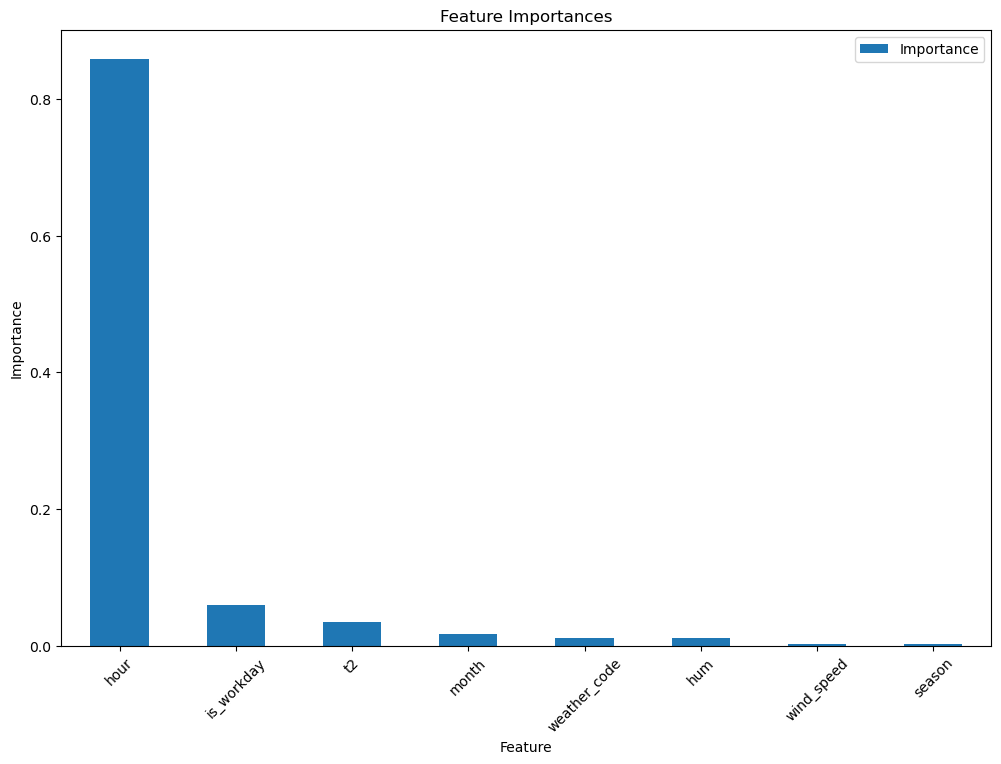

In [32]:
# Get the feature importances
feature_importances = dt_regressor1.feature_importances_

# Create a DataFrame to visualize the feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X1.columns,
    'Importance': feature_importances
})
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
feature_importances_df.plot(kind='bar', x='Feature', y='Importance', figsize=(12, 8))
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

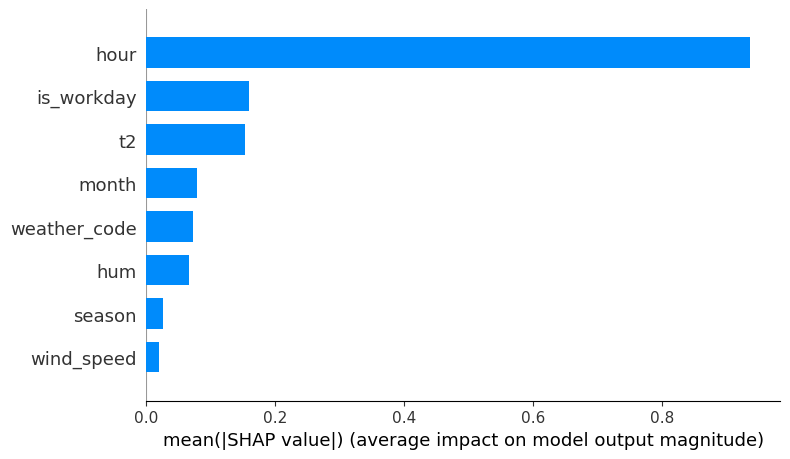

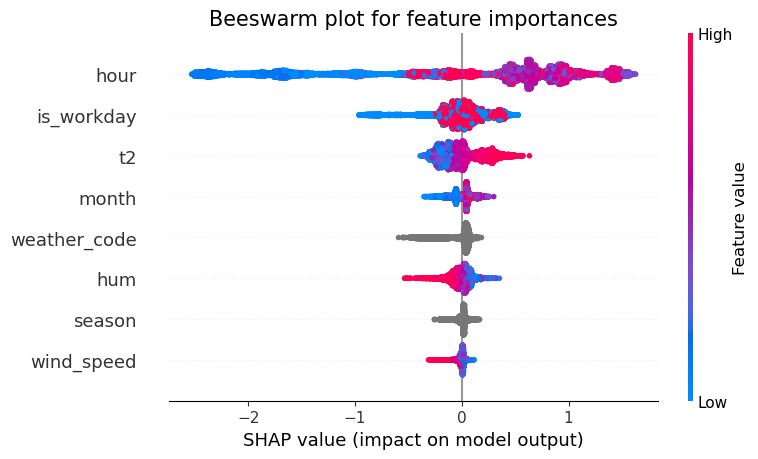

In [33]:
import shap

# Create the SHAP explainer
explainer = shap.TreeExplainer(dt_regressor1)

# Calculate the SHAP values for the test data
shap_values = explainer.shap_values(X1_train)

# Visualize the feature importance using a SHAP summary plot
shap.summary_plot(shap_values, X1_test, plot_type='bar')

# Visualize the SHAP values for individual predictions
plt.title('Beeswarm plot for feature importances', fontsize=15)
shap.summary_plot(shap_values, X1_train, show=False)
plt.savefig('shap_plot.png')
plt.show()

Similarity is that the weather code is all 10.0, which refers to light rain. However, there are only 14 of such observations over the entire dataframe, which may make prediction difficult. In that case, we consider changing the weather to rain/not rain

## XGBoost Regressor 1

In [34]:
# Defining xgboost gridsearchcv and regressor

def xgb_gridsearchcv(X,y):
    xgb_regressor = xgb.XGBRegressor(enable_categorical=True)

    # Define the hyperparameters for tuning
    params = {
        'n_estimators': [30, 50, 100, 150],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.2, 0.1, 0.01, 0.001],
        }
    
    # perform hyperparameter tuning using gridsearch
    grid_search = grid_search = GridSearchCV(estimator=xgb_regressor,
                              param_grid=params,
                              scoring={'neg_root_mean_squared_error': 'neg_root_mean_squared_error', 
                                    'r2_score': 'r2'},
                              refit='neg_root_mean_squared_error',
                              cv=5,
                              n_jobs=-1)
    
    grid_search.fit(X, y)
    
    # Print the best hyperparameters and the corresponding RSME score
    print('Best hyperparameters: ', grid_search.best_params_)
    print('Best RMSE score: ', -grid_search.best_score_)
    print('Best R^2 score: ', grid_search.cv_results_['mean_test_r2_score'][grid_search.best_index_])
    return grid_search

def xgb_regressor(X_train, y_train, X_test, y_test, grid_search):

    # XGBoost model
    xgb_regressor = grid_search.best_estimator_
    xgb_regressor.fit(X_train, y_train)
    
    # Predict
    y_pred = xgb_regressor.predict(X_test)
    
    # evaluation metrics for predictive model
    print ('RMSE Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('Actual MAE (in original scale):', metrics.mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))
    print ('R2 score =', metrics.r2_score(y_test, y_pred)) 
    
    return xgb_regressor, y_pred


In [35]:
# Prediction
xgb_regressor1, y12_pred = xgb_regressor(X1_train, y1_train, X1_test, y1_test, xgb_gridsearchcv(X1, y1))

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Best RMSE score:  0.27065972211475675
Best R^2 score:  0.9535512229360593
RMSE Error: 0.3005583606768043
Actual MAE (in original scale): 191.95645903883874
R2 score = 0.9440257640537217


## Model 2
Based on EDA and SHAP feature importances, we further engineer/simplify the features used in the models.

In [36]:
bike1.head()

,cnt,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,is_workday,is_night,logcnt
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,1,0,1,5.209486
2015-01-04 01:00:00,138,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,1,0,1,4.934474
2015-01-04 02:00:00,134,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,1,0,1,4.905275
2015-01-04 03:00:00,72,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,1,0,1,4.290459
2015-01-04 04:00:00,47,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,1,0,1,3.871201


In [37]:
# Feature engineering Rain
bad_weather = [7.0, 26.0, 10.0]
bike1['bad_weather'] = 0
bike1.loc[bike1['weather_code'].isin(bad_weather), 'bad_weather'] = 1

In [39]:
# Selection features and split
# Compared to X1, the weather_code is changed to bad_weather and season is removed
train_features2 = ['t2', 'hum', 'hour', 'month', 'is_workday', 
                  'bad_weather']

X2 = bike1[train_features2]
y2 = bike1['logcnt']

X2_train, X2_test, y2_train, y2_test = split(X2, y2)

(13931, 6) (3483, 6) (13931,) (3483,)


In [40]:
# Running DT
dt_regressor2, y21_pred = dt_regressor(X2_train, y2_train, X2_test, y2_test, dt_gridsearchcv(X2, y2))

Best hyperparameters:  {'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 10}
Best RMSE score:  0.30556843287370633
Best R^2 score:  0.940950248483729
RSME Error: 0.3228479054492514
Actual MAE (in original scale): 205.61539367005795
R2 score = 0.9354157688490196


In [41]:
# Running XGB
xgb_regressor2, y22_pred = xgb_regressor(X2_train, y2_train, X2_test, y2_test, xgb_gridsearchcv(X2, y2))

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best RMSE score:  0.27389310824322793
Best R^2 score:  0.9524915003236929
RMSE Error: 0.2991811388032179
Actual MAE (in original scale): 192.81226136565996
R2 score = 0.9445375603186736


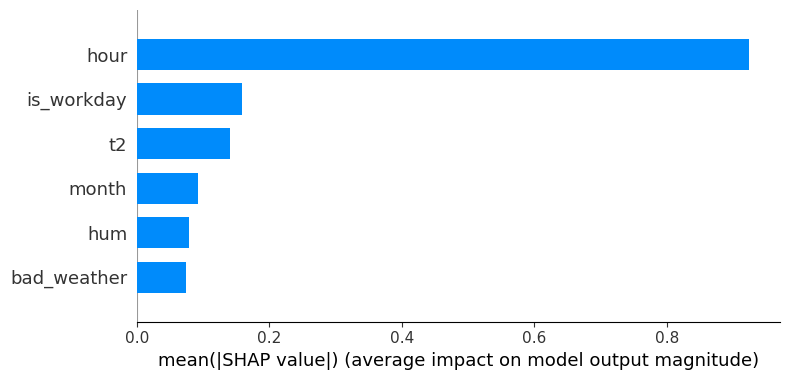

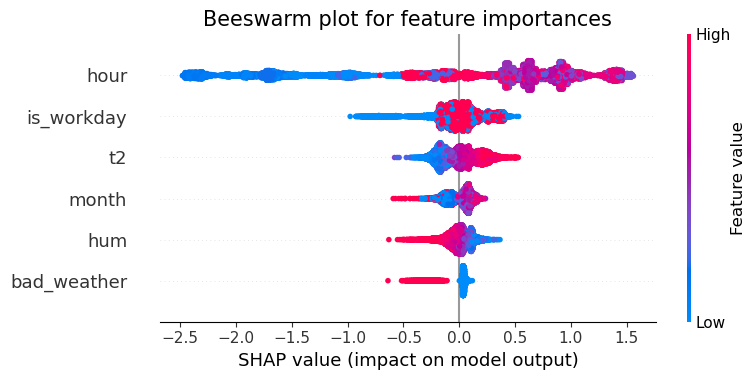

In [42]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(xgb_regressor2)

# Calculate the SHAP values for the test data
shap_values = explainer.shap_values(X2_train)

# Visualize the feature importance using a SHAP summary plot
shap.summary_plot(shap_values, X2_test, plot_type='bar')

# Visualize the SHAP values for individual predictions
plt.title('Beeswarm plot for feature importances', fontsize=15)
shap.summary_plot(shap_values, X2_train, show=False)
plt.savefig('shap_plot2.png')
plt.show()

In [43]:
# Calculate the residuals to investigate limitation of the model
residuals = abs(np.expm1(y2_test)- np.expm1(y22_pred))

large_res = residuals[residuals>500]
large_res = pd.concat([bike1, large_res], axis=1, join='inner')

In [44]:
large_res['is_peak'] = 0
bike.loc[bike['hour'].between(7, 9) | bike['hour'].between(16, 19), 'is_peak'] = 1

In [45]:
large_res.columns

Index(['cnt', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season', 'hour', 'month', 'is_workday', 'is_night',
       'logcnt', 'bad_weather', 'logcnt', 'is_peak'],
      dtype='object')

In [46]:
# You may also test with 'is_peak' here instead of hour
large_res.hour.value_counts().sort_index()

hour
0      1
1      1
7     32
8     54
9     21
10     6
11     6
12    17
13    18
14    14
15    17
16    13
17    66
18    62
19    16
20     5
21     1
Name: count, dtype: int64

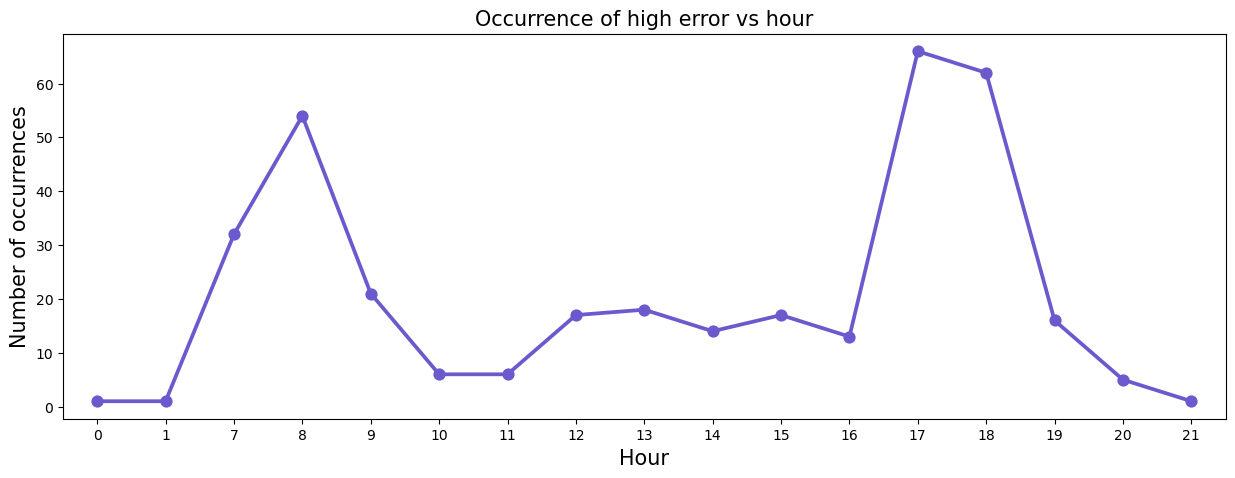

In [47]:
plt.figure(figsize=(15, 5))
ax = sns.pointplot(large_res.hour.value_counts().sort_index(), color='slateblue')
ax.set_title('Occurrence of high error vs hour', fontsize=15)
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Number of occurrences', fontsize=15)
plt.savefig('higherror')

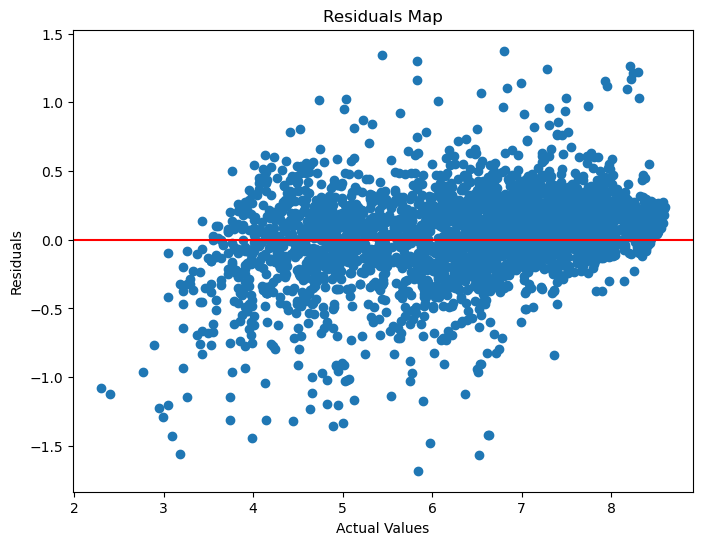

In [48]:
# Plot the residuals map
plt.figure(figsize=(8, 6))
plt.scatter(y1_test, y1_test-y12_pred)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Map')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

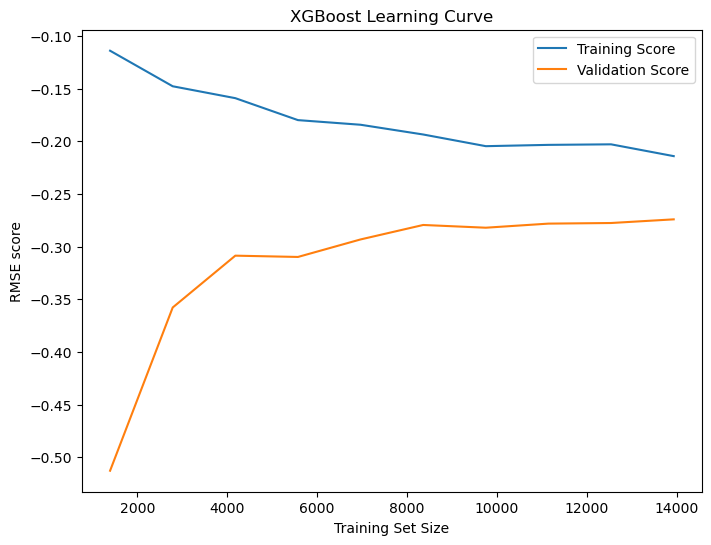

In [49]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=xgb_regressor2,
    X=X2,
    y=y2,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE score')
plt.title('XGBoost Learning Curve')
plt.legend()

### Model 3

This model includes the lagged value to help with prediction. This is supported by the autoregressive nature of the time series data.

In [50]:
# Creating lag values
bike1['lag1'] = bike1['logcnt'].shift()
bike1.shape

(17414, 15)

In [51]:
train_features3 = ['t2', 'hum', 'hour', 'month', 'is_workday', 
                  'bad_weather', 'lag1']

bike2 = bike1.dropna()
X3 = bike2[train_features3]
y3 = bike2['logcnt']

X3_train, X3_test, y3_train, y3_test = split(X3, y3)

(13930, 7) (3483, 7) (13930,) (3483,)


In [52]:
dt_regressor3, y31_pred = dt_regressor(X3_train, y3_train, X3_test, y3_test, dt_gridsearchcv(X3, y3))

Best hyperparameters:  {'max_depth': 12, 'min_samples_leaf': 10, 'min_samples_split': 5}
Best RMSE score:  0.20705919939033998
Best R^2 score:  0.9733311580540341
RSME Error: 0.19984681684563552
Actual MAE (in original scale): 114.69264580075779
R2 score = 0.9752528598445306


In [53]:
# Running XGB
xgb_regressor3, y32_pred = xgb_regressor(X3_train, y3_train, X3_test, y3_test, xgb_gridsearchcv(X3, y3))

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150}
Best RMSE score:  0.1806354567819589
Best R^2 score:  0.9797167775192822
RMSE Error: 0.17690868952724098
Actual MAE (in original scale): 107.49104781565639
R2 score = 0.9806077197695546


### Cross Validation

In [54]:
# We are using the second round of filtered data
# For the test size, we have altogether 2 years of data, so we want to cross validate using 5-folds of 2 months of data per fold.

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*30*2 )

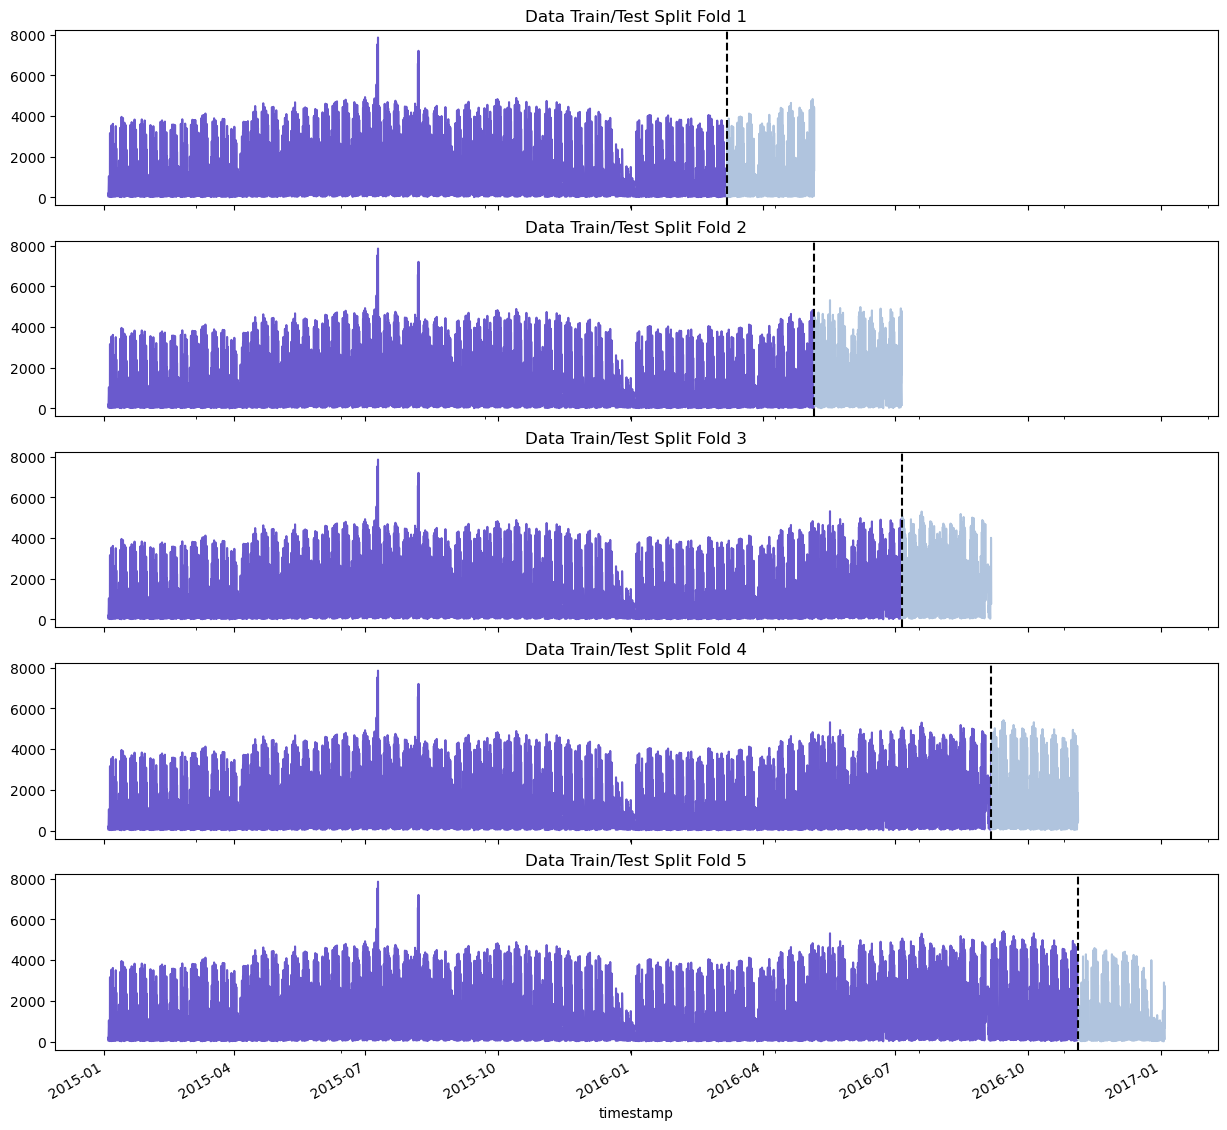

In [55]:
# Visualising the folds
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(bike1):
    train = bike1.iloc[train_idx]
    test = bike1.iloc[val_idx]
    train['cnt'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold+1}',
                     c='slateblue')
    test['cnt'].plot(ax=axs[fold],
                         label='Test Set',
                     c='lightsteelblue')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.savefig('timeseriessplit')
plt.show()

In [56]:
# Conducting the 5-fold cross-validation

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(bike1):
    train = bike1.iloc[train_idx]
    test = bike1.iloc[val_idx]


    ytrain = train['logcnt']
    Xtrain = train[train_features2]
    ytest = test['logcnt']
    Xtest = test[train_features2]

    reg = xgb.XGBRegressor(learning_rate= 0.1, max_depth= 6, n_estimators= 150, enable_categorical=True)
    reg.fit(Xtrain, ytrain)

    ypred = reg.predict(Xtest)
    preds.append(ypred)
    score = metrics.mean_absolute_error(np.expm1(ytest), np.expm1(ypred))
    scores.append(score)

In [60]:
mean_rmse = np.mean(scores)
std_mae = np.std(scores)

mean_rmse, std_mae

(179.19038309150272, 25.65800542581234)

In [ ]:
# Conducting adf test to check the stationarity of the data.

from statsmodels.tsa.stattools import adfuller

result = adfuller(y1)

# Extract and print the p-value
p_value = result[1]
print('p-value:', p_value)

### Prediction

Text(0.5, 1.0, 'Prediction of test set')

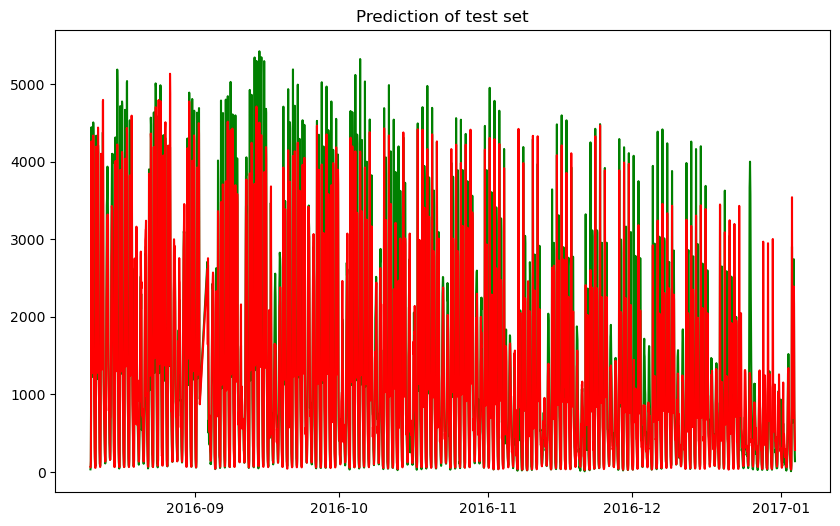

In [58]:
# Prediction

plt.figure(figsize=(10, 6))

y_pred = pd.Series(y22_pred, index = y2_test.index, name='pred')

# Plot y_train
#plt.plot(np.expm1(y_train.loc), color='blue', label='y_train', ms=1)

# Plot y_test
plt.plot(np.expm1(y2_test), color='green', label='y_test')

# Plot y_pred
plt.plot( np.expm1(y_pred), color='red', label='y_pred')

plt.title('Prediction of test set')
